## 1. Setup and Data Loading

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import torch
from scipy.sparse import load_npz, csr_matrix, save_npz
from scipy import stats
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Visualization setup
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)

print(f"PyTorch version: {torch.__version__}")
print(f"MPS available: {torch.backends.mps.is_available()}")

PyTorch version: 2.2.2
MPS available: True


In [2]:
# Load pre-computed features from the feature engineering step
features_dir = './features'

print("=" * 60)
print("LOADING FEATURES")
print("=" * 60)

user_item_matrix = load_npz(f'{features_dir}/user_item_matrix.npz')
bundle_game_matrix = load_npz(f'{features_dir}/bundle_game_matrix.npz')
game_similarity_bundle = load_npz(f'{features_dir}/game_similarity_bundle.npz')
game_similarity_copurchase = load_npz(f'{features_dir}/game_similarity_copurchase.npz')
game_similarity_combined = load_npz(f'{features_dir}/game_similarity_combined.npz')
bundle_similarity_matrix = np.load(f'{features_dir}/bundle_similarity_matrix.npy')

with open(f'{features_dir}/mappings.pkl', 'rb') as f:
    mappings = pickle.load(f)
    user_to_idx = mappings['user_to_idx']
    idx_to_user = mappings['idx_to_user']
    item_to_idx = mappings['item_to_idx']
    idx_to_item = mappings['idx_to_item']
    bundle_to_idx = mappings['bundle_to_idx']
    idx_to_bundle = mappings['idx_to_bundle']

game_popularity_df = pd.read_csv(f'{features_dir}/game_popularity.csv')
popularity_scores = game_popularity_df.sort_values('item_idx')['popularity_score'].values

print(f"✓ Loaded all features")
print(f"  Users: {user_item_matrix.shape[0]:,}")
print(f"  Games: {user_item_matrix.shape[1]:,}")
print(f"  Bundles: {bundle_game_matrix.shape[0]:,}")

LOADING FEATURES
✓ Loaded all features
  Users: 70,912
  Games: 10,978
  Bundles: 613
✓ Loaded all features
  Users: 70,912
  Games: 10,978
  Bundles: 613


In [3]:
# Load train/test split from the previous notebook to ensure consistency
train_matrix = load_npz('./model_outputs/train_matrix.npz')
test_df = pd.read_csv('./model_outputs/test_set.csv')

print(f"✓ Loaded train/test split")
print(f"  Train interactions: {train_matrix.nnz:,}")
print(f"  Test interactions: {len(test_df):,}")

✓ Loaded train/test split
  Train interactions: 4,103,384
  Test interactions: 990,698


In [4]:
# CRITICAL: Schema Validation and Correction
# Ensure that the test DataFrame has both item_idx (for matrix operations) and item_id (for bundle completion)

print("=" * 60)
print("VALIDATING TEST SET SCHEMA")
print("=" * 60)
print("Initial columns:", test_df.columns.tolist())

if 'item_idx' in test_df.columns and 'item_id' not in test_df.columns:
    print("INFO: 'item_id' column not found. Creating from 'item_idx'...")
    test_df['item_id'] = test_df['item_idx'].map(idx_to_item)
    print("✓ 'item_id' column created.")
elif 'item_id' in test_df.columns and 'item_idx' not in test_df.columns:
    print("INFO: 'item_idx' column not found. Creating from 'item_id'...")
    test_df['item_idx'] = test_df['item_id'].map(item_to_idx)
    print("✓ 'item_idx' column created.")
else:
    print("✓ Both 'item_id' and 'item_idx' are present.")

print("Final columns:", test_df.columns.tolist())
print("Test users:", test_df['user_idx'].nunique())

VALIDATING TEST SET SCHEMA
Initial columns: ['user_idx', 'item_idx', 'user_id', 'item_id']
✓ Both 'item_id' and 'item_idx' are present.
Final columns: ['user_idx', 'item_idx', 'user_id', 'item_id']
Test users: 62936


## 2. Model Definitions

Here we define all the recommender classes we will evaluate. This includes our main hybrid recommender, the task-specific models, and the baseline models for comparison.

In [5]:
# Main Hybrid Recommender (GPU-accelerated)
class NextGameRecommender:
    """GPU-accelerated hybrid recommender for Task 1."""
    def __init__(self, train_matrix, similarity_matrix, popularity_scores, alpha=0.7, device=None):
        self.train_matrix = train_matrix
        self.similarity_matrix = similarity_matrix
        self.alpha = alpha

        # Auto-detect Mac GPU (MPS), CUDA, or fallback to CPU
        if device:
            self.device = torch.device(device)
        elif torch.backends.mps.is_available():
            self.device = torch.device("mps")
        elif torch.cuda.is_available():
            self.device = torch.device("cuda")
        else:
            self.device = torch.device("cpu")

        pop = torch.as_tensor(popularity_scores, dtype=torch.float32)
        self.popularity_t = pop.flatten().to(self.device)
        self.n_items = int(self.popularity_t.numel())

    def recommend(self, user_idx, k=10, exclude_owned=True):
        k = int(min(k, self.n_items))
        user_items = self.train_matrix[user_idx].nonzero()[1]

        if len(user_items) == 0:
            top_vals, top_idx = torch.topk(self.popularity_t, k)
            return [(int(i), float(v)) for i, v in zip(top_idx.tolist(), top_vals.tolist())]

        user_profile = self.train_matrix[user_idx]
        scores_np = user_profile.dot(self.similarity_matrix).toarray().ravel()
        scores_np = scores_np / float(len(user_items))
        scores_t = torch.from_numpy(scores_np).to(self.device, dtype=torch.float32)

        combined_scores_t = self.alpha * scores_t + (1 - self.alpha) * self.popularity_t

        if exclude_owned:
            user_items_t = torch.tensor(user_items, device=self.device, dtype=torch.long)
            combined_scores_t.index_fill_(0, user_items_t, float("-inf"))

        top_vals, top_idx = torch.topk(combined_scores_t, k)
        return [(int(i), float(v)) for i, v in zip(top_idx.tolist(), top_vals.tolist())]

# Task 2 Recommender (Corrected)
class BundleCompletionRecommender:
    """Recommends games to complete partially owned bundles."""
    def __init__(self, user_item_matrix, bundle_game_matrix, idx_to_item, item_to_idx):
        self.user_item_matrix = user_item_matrix
        self.bundle_game_matrix = bundle_game_matrix
        self.idx_to_item = idx_to_item
        self.item_to_idx = item_to_idx # Added for ID-to-Index conversion

    def get_partial_bundles(self, user_idx):
        user_game_indices = set(self.user_item_matrix[user_idx].nonzero()[1])
        partial_bundles = []
        for bundle_idx in range(self.bundle_game_matrix.shape[0]):
            bundle_game_indices = set(self.bundle_game_matrix[bundle_idx].nonzero()[1])
            if not bundle_game_indices: continue
            owned = user_game_indices & bundle_game_indices
            ownership_ratio = len(owned) / len(bundle_game_indices)
            if 0 < ownership_ratio < 1:
                partial_bundles.append({
                    'bundle_idx': bundle_idx,
                    'ownership_ratio': ownership_ratio,
                    'missing_indices': bundle_game_indices - user_game_indices
                })
        return sorted(partial_bundles, key=lambda x: x['ownership_ratio'], reverse=True)

    def recommend(self, user_idx, k=10, min_ownership=0.3):
        partial_bundles = self.get_partial_bundles(user_idx)
        game_scores = defaultdict(float)
        for bundle in partial_bundles:
            if bundle['ownership_ratio'] >= min_ownership:
                for item_idx in bundle['missing_indices']:
                    game_scores[item_idx] = max(game_scores[item_idx], bundle['ownership_ratio'])
        return sorted(game_scores.items(), key=lambda x: x[1], reverse=True)[:k]

# Task 3 Recommender
class CrossBundleRecommender:
    """Discovers similar bundles based on content."""
    def __init__(self, bundle_similarity_matrix, idx_to_bundle):
        self.bundle_similarity_matrix = bundle_similarity_matrix
        self.idx_to_bundle = idx_to_bundle

    def recommend(self, bundle_idx, k=5, min_similarity=0.1):
        similarities = self.bundle_similarity_matrix[bundle_idx].copy()
        similarities[bundle_idx] = -np.inf
        valid_indices = np.where(similarities >= min_similarity)[0]
        if len(valid_indices) == 0: return []
        top_indices = valid_indices[np.argsort(-similarities[valid_indices])[:k]]
        return [{'bundle_idx': int(idx), 'bundle_id': self.idx_to_bundle.get(int(idx)), 'similarity': float(similarities[idx])} for idx in top_indices]

# Baseline Recommenders
class PopularityRecommender:
    def __init__(self, train_matrix, popularity_scores):
        self.train_matrix = train_matrix
        self.popularity_scores = popularity_scores

    def recommend(self, user_idx, k=10, exclude_owned=True):
        scores = self.popularity_scores.copy()
        if exclude_owned:
            scores[self.train_matrix[user_idx].nonzero()[1]] = -np.inf
        top_k = np.argsort(-scores)[:k]
        return [(int(idx), float(scores[idx])) for idx in top_k]

class RandomRecommender:
    def __init__(self, train_matrix, n_items):
        self.train_matrix = train_matrix
        self.n_items = n_items
        np.random.seed(42)

    def recommend(self, user_idx, k=10, exclude_owned=True):
        user_items = set(self.train_matrix[user_idx].nonzero()[1]) if exclude_owned else set()
        candidates = [i for i in range(self.n_items) if i not in user_items]
        return [(int(idx), 1.0) for idx in np.random.choice(candidates, size=min(k, len(candidates)), replace=False)]

print("✓ All model classes defined.")

✓ All model classes defined.


## 3. Phase 1: Core Model Validation

### 3.1 Evaluation Functions (with NDCG and Confidence Intervals)

To ensure our evaluation is robust, we define a comprehensive evaluation function that calculates:
- **Precision@K**: Accuracy of recommendations.
- **Recall@K**: Coverage of relevant items.
- **Hit Rate@K**: If at least one relevant item was recommended.
- **NDCG@K**: Normalized Discounted Cumulative Gain, a measure of ranking quality. It rewards models for placing relevant items higher in the list.

We also add a function to compute **95% confidence intervals** to verify that performance differences are statistically significant.

In [6]:
def ndcg_at_k(true_items, predicted_items, k):
    """Calculate NDCG@K for a single user."""
    dcg = sum(1.0 / np.log2(i + 2) for i, item in enumerate(predicted_items[:k]) if item in true_items)
    idcg = sum(1.0 / np.log2(i + 2) for i in range(min(len(true_items), k)))
    return dcg / idcg if idcg > 0 else 0.0

def evaluate_recommender(recommender, test_df, k_values=[5, 10, 20], max_users=None):
    """Comprehensive evaluation for a recommender, including NDCG."""
    test_grouped = test_df.groupby('user_idx')['item_idx'].apply(set).to_dict()
    users_to_eval = list(test_grouped.keys())[:max_users]
    
    # Store individual scores for each user to calculate confidence intervals later
    raw_results = {k: defaultdict(list) for k in k_values}
    max_k = max(k_values)

    for i, user_idx in enumerate(users_to_eval):
        if i > 0 and i % 5000 == 0: print(f"  Progress: {i}/{len(users_to_eval)} users...")
        
        true_items = test_grouped[user_idx]
        if not true_items: continue

        recs = recommender.recommend(user_idx, k=max_k)
        rec_indices = [item_idx for item_idx, score in recs]

        for k in k_values:
            k_recs = rec_indices[:k]
            hits = len(true_items & set(k_recs))
            raw_results[k]['precision'].append(hits / k if k > 0 else 0)
            raw_results[k]['recall'].append(hits / len(true_items))
            raw_results[k]['hit_rate'].append(1 if hits > 0 else 0)
            raw_results[k]['ndcg'].append(ndcg_at_k(true_items, k_recs, k))
    
    # Summarize by taking the mean
    summary = {k: {metric: np.mean(scores) for metric, scores in metrics.items()} for k, metrics in raw_results.items()}
    return summary, raw_results # Return raw scores as well for CI calculation

def with_confidence_intervals(raw_scores_dict, confidence=0.95):
    """Calculate mean and 95% confidence interval for each metric."""
    summary_with_ci = {}
    for k, metrics in raw_scores_dict.items():
        summary_with_ci[k] = {}
        for metric, scores in metrics.items():
            if not scores: continue
            mean = np.mean(scores)
            sem = stats.sem(scores)
            ci = sem * stats.t.ppf((1 + confidence) / 2., len(scores)-1)
            summary_with_ci[k][metric] = {'mean': mean, 'ci': ci}
    return summary_with_ci

print("✓ Advanced evaluation functions defined.")

✓ Advanced evaluation functions defined.


### 3.2 Alpha Parameter Tuning

The `NextGameRecommender` uses a hybrid score: `α * similarity + (1-α) * popularity`. The `alpha` parameter controls this balance. We test several values on a subset of users to find the optimal balance efficiently.

In [7]:
print("=" * 60)
print("PHASE 1: ALPHA PARAMETER TUNING")
print("=" * 60)

alphas_to_test = [0.3, 0.5, 0.7, 0.9]
alpha_results = {}

for alpha in alphas_to_test:
    print(f"\nTesting alpha={alpha} (similarity weight)...")
    recommender = NextGameRecommender(train_matrix, game_similarity_combined, popularity_scores, alpha=alpha)
    # Use a subset of 10,000 users for faster tuning
    results, _ = evaluate_recommender(recommender, test_df, max_users=10000)
    alpha_results[alpha] = results
    print(f"  HR@10: {results[10]['hit_rate']:.4f} | NDCG@10: {results[10]['ndcg']:.4f}")

best_alpha = max(alpha_results, key=lambda a: alpha_results[a][10]['hit_rate'])
print(f"\n✓ Best alpha based on Hit Rate@10: {best_alpha}")

PHASE 1: ALPHA PARAMETER TUNING

Testing alpha=0.3 (similarity weight)...
  Progress: 5000/10000 users...
  Progress: 5000/10000 users...
  HR@10: 0.7988 | NDCG@10: 0.2623

Testing alpha=0.5 (similarity weight)...
  HR@10: 0.7988 | NDCG@10: 0.2623

Testing alpha=0.5 (similarity weight)...
  Progress: 5000/10000 users...
  Progress: 5000/10000 users...
  HR@10: 0.8000 | NDCG@10: 0.2636

Testing alpha=0.7 (similarity weight)...
  HR@10: 0.8000 | NDCG@10: 0.2636

Testing alpha=0.7 (similarity weight)...
  Progress: 5000/10000 users...
  Progress: 5000/10000 users...
  HR@10: 0.8011 | NDCG@10: 0.2645

Testing alpha=0.9 (similarity weight)...
  HR@10: 0.8011 | NDCG@10: 0.2645

Testing alpha=0.9 (similarity weight)...
  Progress: 5000/10000 users...
  Progress: 5000/10000 users...
  HR@10: 0.8014 | NDCG@10: 0.2648

✓ Best alpha based on Hit Rate@10: 0.9
  HR@10: 0.8014 | NDCG@10: 0.2648

✓ Best alpha based on Hit Rate@10: 0.9


### 3.3 Baseline & Final Model Comparison

Now we evaluate our best model (using the optimal alpha) against simple baselines on the **full test set**. This demonstrates the value added by our hybrid, bundle-aware approach.

In [9]:
print("=" * 60)
print("PHASE 1: BASELINE & FINAL MODEL EVALUATION")
print("=" * 60)

models_to_evaluate = {
    "Random": RandomRecommender(train_matrix, user_item_matrix.shape[1]),
    "Popularity": PopularityRecommender(train_matrix, popularity_scores),
    f"Combined (α={best_alpha})": NextGameRecommender(train_matrix, game_similarity_combined, popularity_scores, alpha=best_alpha)
}

final_results = {}
final_raw_results = {}

for name, model in models_to_evaluate.items():
    print(f"\nEvaluating: {name}...")
    summary, raw = evaluate_recommender(model, test_df) # Evaluate on full test set
    final_results[name] = summary
    final_raw_results[name] = raw
    print(f"  HR@10: {summary[10]['hit_rate']:.4f} | NDCG@10: {summary[10]['ndcg']:.4f}")

# Add confidence intervals to final results
results_with_ci = {name: with_confidence_intervals(raw) for name, raw in final_raw_results.items()}

print("\n" + "=" * 60)
print("TASK 1 RESULTS (Hit Rate @ 10)")
print("=" * 60)
for name, res in results_with_ci.items():
    mean = res[10]['hit_rate']['mean']
    ci = res[10]['hit_rate']['ci']
    print(f"  {name:<20}: {mean:.4f} ± {ci:.4f}")

PHASE 1: BASELINE & FINAL MODEL EVALUATION

Evaluating: Random...
  Progress: 5000/62936 users...
  Progress: 5000/62936 users...
  Progress: 10000/62936 users...
  Progress: 10000/62936 users...
  Progress: 15000/62936 users...
  Progress: 15000/62936 users...
  Progress: 20000/62936 users...
  Progress: 20000/62936 users...
  Progress: 25000/62936 users...
  Progress: 25000/62936 users...
  Progress: 30000/62936 users...
  Progress: 30000/62936 users...
  Progress: 35000/62936 users...
  Progress: 35000/62936 users...
  Progress: 40000/62936 users...
  Progress: 40000/62936 users...
  Progress: 45000/62936 users...
  Progress: 45000/62936 users...
  Progress: 50000/62936 users...
  Progress: 50000/62936 users...
  Progress: 55000/62936 users...
  Progress: 55000/62936 users...
  Progress: 60000/62936 users...
  Progress: 60000/62936 users...
  HR@10: 0.0140 | NDCG@10: 0.0016

Evaluating: Popularity...
  HR@10: 0.0140 | NDCG@10: 0.0016

Evaluating: Popularity...
  Progress: 5000/62936

## 4. Phase 2: Task-Specific Evaluation

### 4.1 Task 2: Bundle Completion Evaluation

Here we evaluate the `BundleCompletionRecommender`. The key metric is **Bundle Precision**, which measures what percentage of recommendations are for games that would help a user complete a partially owned bundle. A high score proves the model is effectively targeting bundle completion.

In [10]:
def evaluate_bundle_completion(recommender, test_df, k_values=[5, 10, 20]):
    print(f"\nEvaluating Bundle Completion Recommender...")
    actual_by_user = test_df.groupby('user_idx')['item_idx'].apply(set).to_dict()
    test_users = list(actual_by_user.keys())

    raw_results = {k: defaultdict(list) for k in k_values}
    users_with_partial_bundles = 0
    max_k = max(k_values)

    for i, user_idx in enumerate(test_users):
        if i > 0 and i % 5000 == 0: print(f"  Progress: {i}/{len(test_users)} users...")

        partial_bundles = recommender.get_partial_bundles(user_idx)
        if not partial_bundles: continue

        users_with_partial_bundles += 1
        recs = recommender.recommend(user_idx, k=max_k, min_ownership=0.3)
        if not recs: continue

        rec_indices = [item_idx for item_idx, score in recs]
        actual_items = actual_by_user.get(user_idx, set())

        all_missing_indices = {idx for bundle in partial_bundles for idx in bundle['missing_indices']}

        for k in k_values:
            k_recs_set = set(rec_indices[:k])
            hits = len(actual_items & k_recs_set)
            raw_results[k]['precision'].append(hits / k if k > 0 else 0)
            raw_results[k]['hit_rate'].append(1 if hits > 0 else 0)
            raw_results[k]['bundle_precision'].append(len(k_recs_set & all_missing_indices) / k if k > 0 else 0)

    print(f"\n✓ Evaluated on {users_with_partial_bundles:,} users with partial bundles.")
    summary = {k: {metric: np.mean(scores) for metric, scores in metrics.items()} for k, metrics in raw_results.items()}
    return summary, raw_results

print("=" * 60)
print("PHASE 2: BUNDLE COMPLETION EVALUATION")
print("=" * 60)

bundle_recommender = BundleCompletionRecommender(train_matrix, bundle_game_matrix, idx_to_item, item_to_idx)
task2_summary, task2_raw = evaluate_bundle_completion(bundle_recommender, test_df)
task2_ci = with_confidence_intervals(task2_raw)

print("\n" + "=" * 60)
print("TASK 2 RESULTS (K=10)")
print("=" * 60)
hr_mean = task2_ci[10]['hit_rate']['mean']
hr_ci = task2_ci[10]['hit_rate']['ci']
bp_mean = task2_ci[10]['bundle_precision']['mean']
bp_ci = task2_ci[10]['bundle_precision']['ci']
print(f"  Hit Rate          : {hr_mean:.4f} ± {hr_ci:.4f}")
print(f"  Bundle Precision  : {bp_mean:.4f} ± {bp_ci:.4f}  (proof of bundle-awareness)")

PHASE 2: BUNDLE COMPLETION EVALUATION

Evaluating Bundle Completion Recommender...
  Progress: 5000/62936 users...
  Progress: 5000/62936 users...
  Progress: 10000/62936 users...
  Progress: 10000/62936 users...
  Progress: 15000/62936 users...
  Progress: 15000/62936 users...
  Progress: 20000/62936 users...
  Progress: 20000/62936 users...
  Progress: 25000/62936 users...
  Progress: 25000/62936 users...
  Progress: 30000/62936 users...
  Progress: 30000/62936 users...
  Progress: 35000/62936 users...
  Progress: 35000/62936 users...
  Progress: 40000/62936 users...
  Progress: 40000/62936 users...
  Progress: 45000/62936 users...
  Progress: 45000/62936 users...
  Progress: 50000/62936 users...
  Progress: 50000/62936 users...
  Progress: 55000/62936 users...
  Progress: 55000/62936 users...
  Progress: 60000/62936 users...
  Progress: 60000/62936 users...

✓ Evaluated on 57,773 users with partial bundles.

TASK 2 RESULTS (K=10)
  Hit Rate          : 0.4409 ± 0.0041
  Bundle Precis

### 4.2 Task 3: Cross-Bundle Discovery Evaluation

For this task, we evaluate the quality of bundle recommendations based on:
- **Similarity**: Are the recommended bundles actually similar?
- **Diversity**: Are they too similar? High diversity means we recommend a good variety.
- **User Overlap**: Do users who bought the source bundle also tend to buy the recommended bundles? This is a strong proxy for relevance.

In [11]:
def evaluate_cross_bundle_discovery(recommender, bundle_game_matrix, user_item_matrix, k=5):
    print(f"\nEvaluating Cross-Bundle Discovery...")
    results = defaultdict(list)
    bundles_with_recs = 0
    n_bundles = bundle_game_matrix.shape[0]

    # Pre-calculate users per game for speed
    users_per_game = [set(user_item_matrix[:, i].nonzero()[0]) for i in range(user_item_matrix.shape[1])]

    for bundle_idx in range(n_bundles):
        similar = recommender.recommend(bundle_idx, k=k)
        if not similar: continue

        bundles_with_recs += 1
        source_games = set(bundle_game_matrix[bundle_idx].nonzero()[1])
        if not source_games: continue

        source_users = set().union(*(users_per_game[i] for i in source_games))

        for rec in similar:
            results['similarity'].append(rec['similarity'])
            rec_games = set(bundle_game_matrix[rec['bundle_idx']].nonzero()[1])
            if rec_games:
                union_size = len(source_games | rec_games)
                results['diversity'].append(1 - (len(source_games & rec_games) / union_size if union_size > 0 else 0))
                rec_users = set().union(*(users_per_game[i] for i in rec_games))
                if rec_users and source_users:
                    user_union_size = len(source_users | rec_users)
                    results['user_overlap'].append(len(source_users & rec_users) / user_union_size if user_union_size > 0 else 0)

    summary = {metric: np.mean(scores) for metric, scores in results.items()}
    summary['coverage'] = bundles_with_recs / n_bundles
    return summary

print("=" * 60)
print("PHASE 2: CROSS-BUNDLE DISCOVERY EVALUATION")
print("=" * 60)

cross_bundle_recommender = CrossBundleRecommender(bundle_similarity_matrix, idx_to_bundle)
task3_summary = evaluate_cross_bundle_discovery(cross_bundle_recommender, bundle_game_matrix, user_item_matrix)

print("\n" + "=" * 60)
print("TASK 3 RESULTS")
print("=" * 60)
print(f"  Coverage         : {task3_summary['coverage']:.2%} of bundles have recommendations")
print(f"  Average Similarity : {task3_summary['similarity']:.4f}")
print(f"  Average Diversity  : {task3_summary['diversity']:.4f} (1 = totally different)")
print(f"  Average User Overlap: {task3_summary['user_overlap']:.4f} (Jaccard of user bases)")

PHASE 2: CROSS-BUNDLE DISCOVERY EVALUATION

Evaluating Cross-Bundle Discovery...

TASK 3 RESULTS
  Coverage         : 41.92% of bundles have recommendations
  Average Similarity : 0.4928
  Average Diversity  : 0.6829 (1 = totally different)
  Average User Overlap: 0.4439 (Jaccard of user bases)

TASK 3 RESULTS
  Coverage         : 41.92% of bundles have recommendations
  Average Similarity : 0.4928
  Average Diversity  : 0.6829 (1 = totally different)
  Average User Overlap: 0.4439 (Jaccard of user bases)


## 5. Visualization and Final Summary

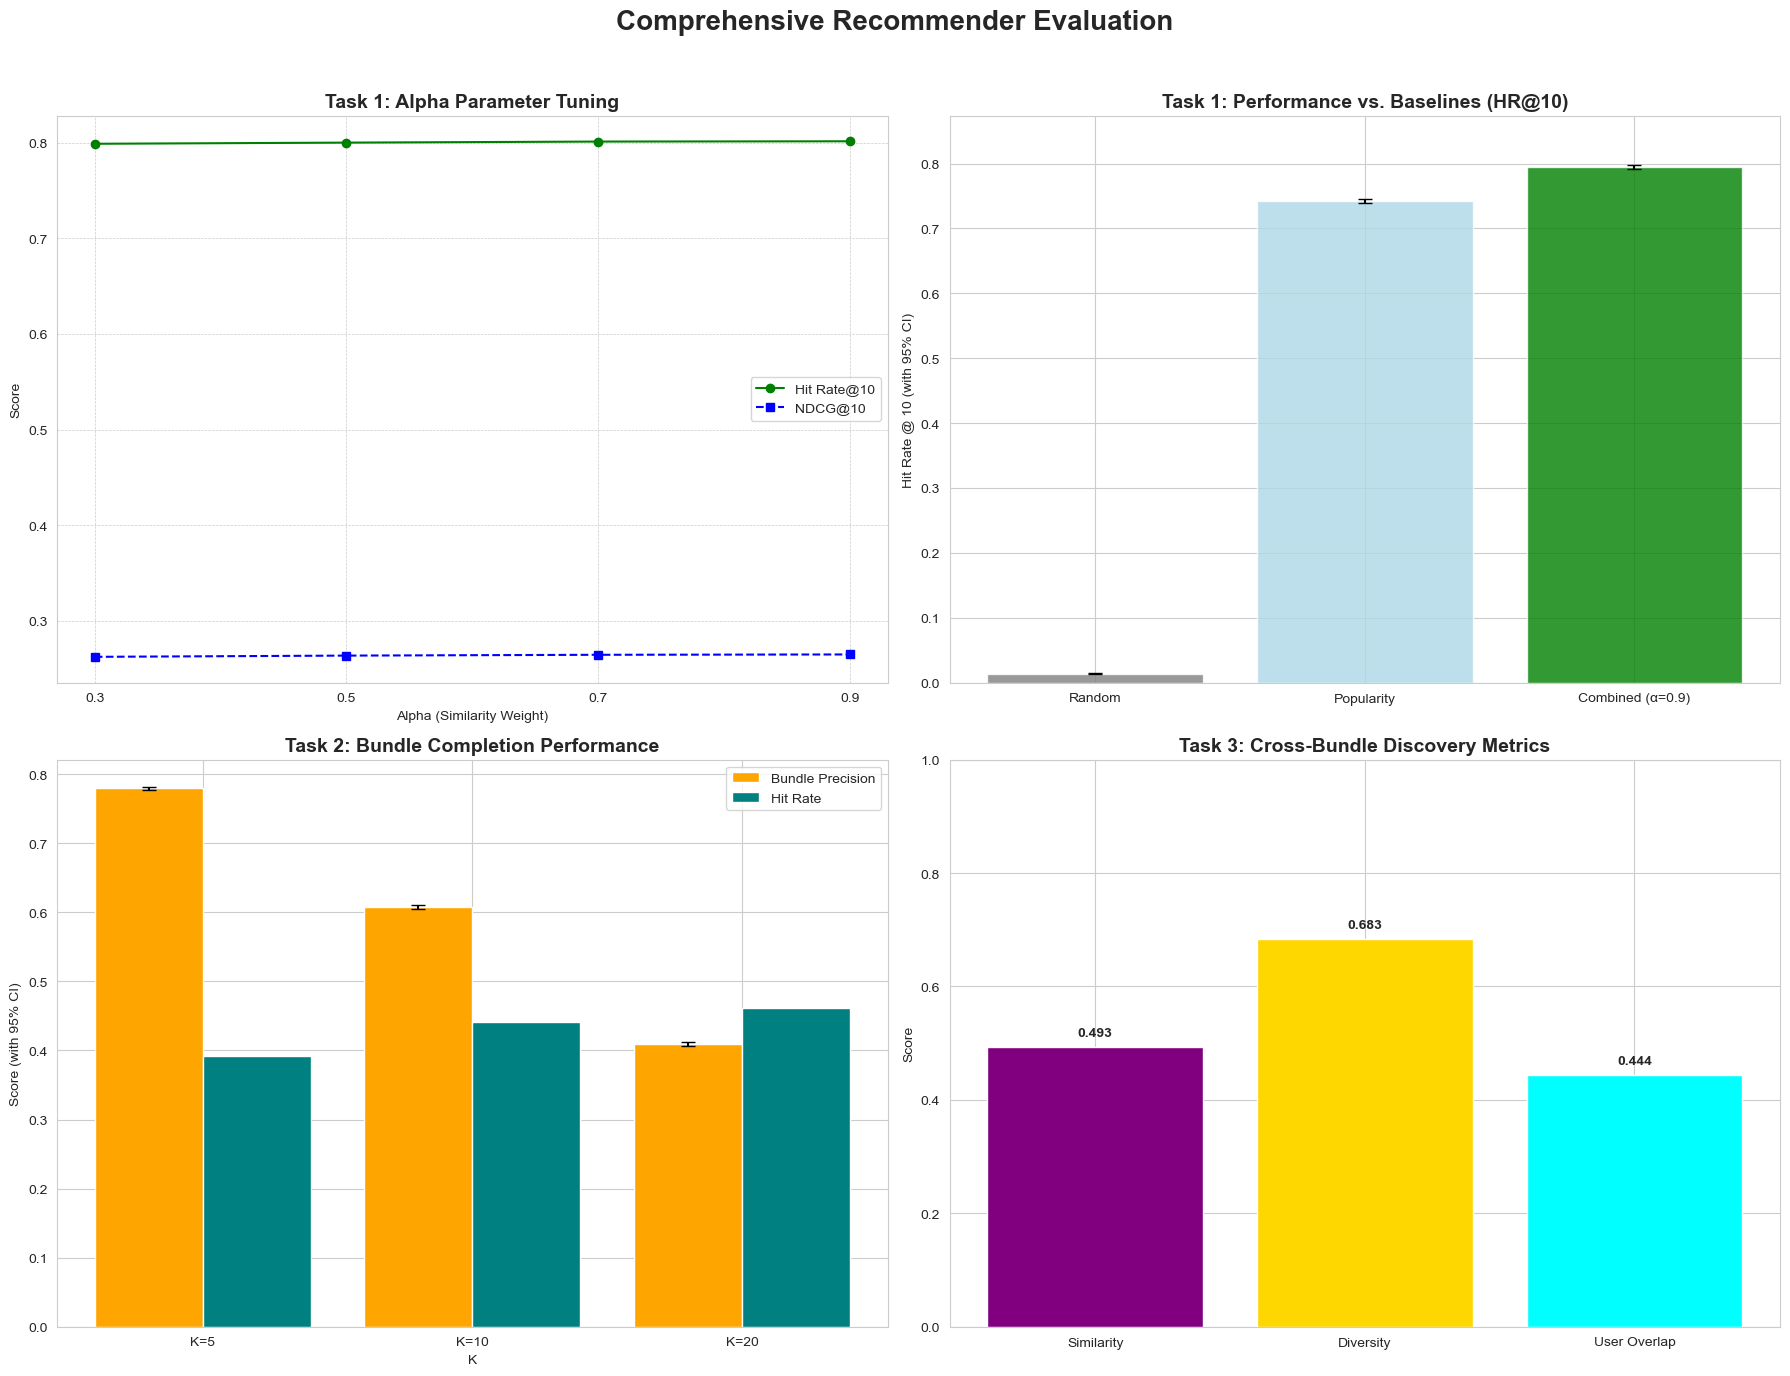

In [12]:
# Plotting the comprehensive results
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Comprehensive Recommender Evaluation', fontsize=20, fontweight='bold')

# 1. Alpha Tuning Plot
ax1 = axes[0, 0]
alphas = list(alpha_results.keys())
hr_values = [alpha_results[a][10]['hit_rate'] for a in alphas]
ndcg_values = [alpha_results[a][10]['ndcg'] for a in alphas]
x = np.arange(len(alphas))
ax1.plot(x, hr_values, marker='o', linestyle='-', label='Hit Rate@10', color='g')
ax1.plot(x, ndcg_values, marker='s', linestyle='--', label='NDCG@10', color='b')
ax1.set_title('Task 1: Alpha Parameter Tuning', fontsize=14, fontweight='bold')
ax1.set_xlabel('Alpha (Similarity Weight)')
ax1.set_ylabel('Score')
ax1.set_xticks(x)
ax1.set_xticklabels(alphas)
ax1.legend()
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# 2. Baseline Comparison Plot
ax2 = axes[0, 1]
model_names = list(results_with_ci.keys())
hr_means = [res[10]['hit_rate']['mean'] for res in results_with_ci.values()]
hr_cis = [res[10]['hit_rate']['ci'] for res in results_with_ci.values()]
ax2.bar(model_names, hr_means, yerr=hr_cis, capsize=5, color=['gray', 'lightblue', 'green'], alpha=0.8)
ax2.set_title('Task 1: Performance vs. Baselines (HR@10)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Hit Rate @ 10 (with 95% CI)')
ax2.set_ylim(0, max(hr_means) * 1.1)

# 3. Task 2 Plot
ax3 = axes[1, 0]
k_vals = list(task2_ci.keys())
bp_means = [task2_ci[k]['bundle_precision']['mean'] for k in k_vals]
bp_cis = [task2_ci[k]['bundle_precision']['ci'] for k in k_vals]
hr_means_t2 = [task2_ci[k]['hit_rate']['mean'] for k in k_vals]
ax3.bar(np.arange(len(k_vals)) - 0.2, bp_means, width=0.4, yerr=bp_cis, capsize=5, label='Bundle Precision', color='orange')
ax3.bar(np.arange(len(k_vals)) + 0.2, hr_means_t2, width=0.4, label='Hit Rate', color='teal')
ax3.set_title('Task 2: Bundle Completion Performance', fontsize=14, fontweight='bold')
ax3.set_xlabel('K')
ax3.set_ylabel('Score (with 95% CI)')
ax3.set_xticks(np.arange(len(k_vals)))
ax3.set_xticklabels([f"K={k}" for k in k_vals])
ax3.legend()

# 4. Task 3 Plot
ax4 = axes[1, 1]
metrics = ['Similarity', 'Diversity', 'User Overlap']
values = [task3_summary[m.lower().replace(' ', '_')] for m in metrics]
ax4.bar(metrics, values, color=['purple', 'gold', 'cyan'])
ax4.set_title('Task 3: Cross-Bundle Discovery Metrics', fontsize=14, fontweight='bold')
ax4.set_ylabel('Score')
ax4.set_ylim(0, 1)
for i, v in enumerate(values):
    ax4.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('./model_outputs/comprehensive_evaluation_summary.png', dpi=300)
plt.show()

In [13]:
# Save all results to a single JSON file
final_summary = {
    'task1_results': results_with_ci,
    'task2_results': task2_ci,
    'task3_results': task3_summary,
    'best_alpha': best_alpha
}

with open('./model_outputs/comprehensive_results.json', 'w') as f:
    json.dump(final_summary, f, indent=2)

print("✓ All evaluation results saved to ./model_outputs/comprehensive_results.json")

✓ All evaluation results saved to ./model_outputs/comprehensive_results.json
